In [122]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score, make_scorer, log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import pandas as pd

In [123]:
data_train = pd.read_csv('features.csv', index_col = 'match_id')
y_train = data_train['radiant_win']
lst = filter(lambda k: not k in ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire',
                                 'barracks_status_radiant', 'barracks_status_dire'], data_train.columns)
X_train = data_train[lst]
X_train = X_train.fillna(0)

In [124]:

gen = KFold(shuffle = True, n_splits = 5)
scores = []
for n_estimators in [10, 20, 30]:
    clf = GradientBoostingClassifier(n_estimators = n_estimators)
    scores.append(cross_val_score(clf, X_train, y_train, cv = gen, scoring = make_scorer(roc_auc_score)).mean())

    

In [125]:
scores

[0.605532917794165, 0.6248440268971216, 0.631510226812595]

## Отчет 1
1) Какие признаки имеют пропуски в значениях? Давайте их найдем.

In [126]:
filter(lambda k: data_train[k].count() < data_train.shape[0], data_train.columns )

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

Признаки, связанные с первым убийством, объяснить просто. Во многих играх за первые пять минут его просто могло не произойти из-за осторожности игроков, вот и поля остались пустыми. Признаки, связанные с наличием определенного предмета также объясняются несложно: у игроков не дошли руки, чтобы их купить. Обычно ранняя покупка данных предметов свидетельствует о хорошем положении дел для команды, если стоит пропуск, то похоже, у команды меньше шансов на победу. 

2) Как называется столбец, содержащий целевую переменную? Победил свет или тьма: radiant_win.

3) Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось?

Давайте измерим:

In [127]:
import time
import datetime
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators = 30)
score = cross_val_score(clf, X_train, y_train, cv = gen, scoring = make_scorer(roc_auc_score)).mean()
print 'Time elapsed:', datetime.datetime.now() - start_time
print 'Score on cross-validation:', score

Time elapsed: 0:01:28.590466
Score on cross-validation: 0.6319223435753194


Видно, что алгоритм работал 1 минуту и 28 секунды. Это немало. 

4) Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев? 

На мой взгляд, имеет мало смысла использовать больше деревьев. Нам представлена достаточно большая выборка и переобучения, к которому склонен градиентный бустинг, можно надеяться избежать. Но как видно выше, рост качества при росте количества деревьев несущественен. Между 10-ю и 30-ю деревьями качество отличается на 5 сотых, что не так много. С повышением числа деревьев выше 30, следует ожидать замедление роста качества (а он и так маленький) вместе с ростом времени на обучение. Поэтому если производительность компьютеров достаточная, то можно количество деревьев увеличить, но чтобы существенно изменить качество, этого может оказаться недостаточно. 

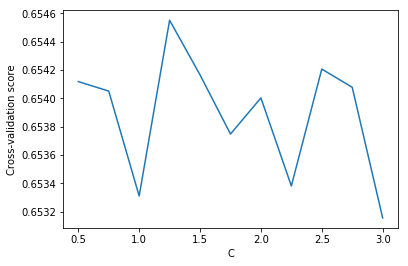

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
X_train_scaled = StandardScaler().fit_transform(X_train)
scores = []
times = []
for C in np.linspace(0.5, 3, 11):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(penalty = 'l2')
    scores.append(cross_val_score(clf, X_train_scaled, y_train, cv = gen, scoring = make_scorer(roc_auc_score)).mean())
    times.append(datetime.datetime.now() - start_time)
plt.plot(np.linspace(0.5, 3, 11), scores, label = 'CV scores on different C')
plt.xlabel('C')
plt.ylabel('Cross-validation score')
plt.show()


In [129]:
print 'Max cross-validation score:', max(scores)
print 'Optimal C:', np.linspace(0.5, 3, 11)[np.argmax(scores)]
print 'Time elapsed:', times[np.argmax(scores)]

Max cross-validation score: 0.6545502800652166
Optimal C: 1.25
Time elapsed: 0:00:13.660754


Теперь без категориальных признаков:

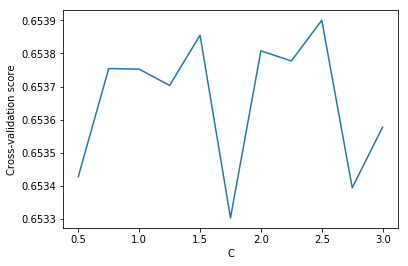

In [130]:
cat_cols = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
            'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
num_cols = filter(lambda k: not k in cat_cols, X_train.columns)
X_num = X_train[num_cols]
X_cat = X_train[cat_cols]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_num)
scores = []
times = []
for C in np.linspace(0.5, 3, 11):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(penalty = 'l2')
    scores.append(cross_val_score(clf, X_train_scaled, y_train, cv = gen, scoring = make_scorer(roc_auc_score)).mean())
    times.append(datetime.datetime.now() - start_time)
plt.plot(np.linspace(0.5, 3, 11), scores, label = 'CV scores on different C')
plt.xlabel('C')
plt.ylabel('Cross-validation score')
plt.show()


In [131]:
print 'Max cross-validation score without categorial features:', max(scores)
print 'Optimal C without categorial features:', np.linspace(0.5, 3, 11)[np.argmax(scores)]
print 'Time elapsed:', times[np.argmax(scores)]

Max cross-validation score without categorial features: 0.6539003539592784
Optimal C without categorial features: 2.5
Time elapsed: 0:00:12.184793


Заменяем категориальные признаки "мешком слов". Сначала находим максимальное число героев, видно, что оно равно 112.

In [132]:
np.unique(X_train[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
            'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']])


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 109, 110, 112])

Формируем мешок, добавляем признаки и обучаем классификатор

In [133]:
X_pick = np.zeros((X_train.shape[0], 112))

for i, match_id in enumerate(X_train.index):
    for p in xrange(5):
        X_pick[i, X_train.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_train.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

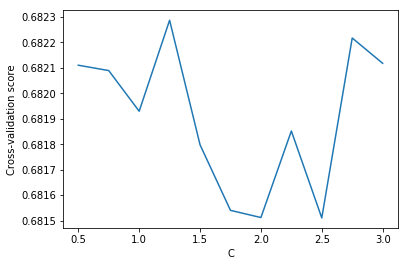

In [134]:
X_train_new = np.hstack((X_train_scaled, X_pick))
scores = []
times = []
for C in np.linspace(0.5, 3, 11):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(penalty = 'l2')
    scores.append(cross_val_score(clf, X_train_new, y_train, cv = gen, scoring = make_scorer(roc_auc_score)).mean())
    times.append(datetime.datetime.now() - start_time)
plt.plot(np.linspace(0.5, 3, 11), scores, label = 'CV scores on different C')
plt.xlabel('C')
plt.ylabel('Cross-validation score')
plt.show()




In [135]:
print 'Max cross-validation score with vectorized categorical features:', max(scores)
print 'Optimal C with vectorized categorical features:', np.linspace(0.5, 3, 11)[np.argmax(scores)]
print 'Time elapsed:', times[np.argmax(scores)]

Max cross-validation score with vectorized categorical features: 0.6822868263038736
Optimal C with vectorized categorical features: 1.25
Time elapsed: 0:00:27.797456


Строим предсказания для тестовой выборки. 

In [136]:
data_test = pd.read_csv('features_test.csv')
lst = filter(lambda k: not k in ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire',
                                 'barracks_status_radiant', 'barracks_status_dire'], data_train.columns)
X_test = data_test[lst]
X_test = X_test.fillna(0)
X_test_scaled = scaler.transform(X_test[num_cols])


/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [137]:
X_pick_test = np.zeros((X_test.shape[0], 112))

for i, match_id in enumerate(X_test.index):
    for p in xrange(5):
        X_pick_test[i, X_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, X_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [138]:
X_test_finished = np.hstack((X_test_scaled, X_pick_test))
clf = LogisticRegression(penalty = 'l2', C = 1.25)
clf.fit(X_train_new, y_train)
win_scores = clf.predict_proba(X_test_finished)[:, 1]


In [139]:
print win_scores[:10]
print 'Maximum probability of winning:', np.max(win_scores)
print 'Minimum probability of winning:', np.min(win_scores)

[0.82497783 0.75440599 0.18730497 0.86034881 0.23998871 0.37311305
 0.52875573 0.56537547 0.21344766 0.6726614 ]
Maximum probability of winning: 0.9964323129310254
Minimum probability of winning: 0.008459835401879149


## Отчет 2
1) Качество логистической регрессии над всеми признаками получилось равным примерно 0.654. Видно, что качество получилось немного выше, у градиентного бустинга над 30 деревьями, там было около 0.632. Разница не такая существенная, но её можно объяснить тем, что в градиентном бустинге мы имели слишком мало базовых алгоритмов. Если бы имели больше, то и качество получилось бы выше. Время работы логистической регрессии составило 14 секунд, это много меньше, чем у градиентного бустинга с его 1 минутой и 28 секундами. 

2) Удаление категориальных признаков привело к качеству 0.654, отличимому от прошлого качества лишь в четвертом знаке после точки. Можно сделать вывод, что первая построенная нами регрессия мало использовала значения категориальных признаков (и правда, ведь она читала их как вещественные, а смысла в этом нет).

3) Максимальный индикатор героя, который был использован игроками равен 112. Видно, что игроки ни разу не использовали некоторых героев, например, с индикаторами 107, 108, 111. Поэтому разумно сделать массив, описывающий категориальные признаки, с длиной 112.

4) Мешок слов значительно повысил качество классификации, увеличив его до 0.682. Это произошло из-за возможности учета регрессией категориальных признаков.

5) Минимальное значение равно 0.008, максимальное 0.996.
